In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import os

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import time

In [3]:
import gc

In [4]:
def convert_img(image):
    
    img2 = ((np.array(image) + 1)*127.5).astype(int)
    img2[img2 > 255] = 255
    img2[img2 < 0] = 0
    
    img2 = img2.astype(np.uint8)
    
    return img2

In [5]:
def plot_photo(image):
    
    img2 = ((np.array(image) + 1)*127.5).astype(int)
    img2[img2 > 255] = 255
    img2[img2 < 0] = 0
    
    fig, ax = plt.subplots(6,6, figsize = (15,15))
    
    N = 36
    for k in range(N):
        i =  int(k/6)
        j = k % 6
    
        ax[i,j].imshow(img2[k])
        ax[i,j].tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)
    

def plot_OneLine(image, title):
    
    img2 = ((np.array(image) + 1)*127.5).astype(int)
    img2[img2 > 255] = 255
    img2[img2 < 0] = 0
    
    fig, ax = plt.subplots(1,6, figsize = (15,2.5))
    
    N = 6
    for k in range(N):
    
        ax[k].imshow(img2[k])
        ax[k].tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)
        
    
    ax[0].set_title(title)

In [6]:
import tensorflow as tf
from keras import backend as K

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [7]:
dir_monet = "/kaggle/input/gan-getting-started/monet_jpg/"
dir_photo = "/kaggle/input/gan-getting-started/photo_jpg/"
files_monet = os.listdir(dir_monet)
files_photo = os.listdir(dir_photo)

In [8]:
n1 = len(files_monet)
n2 = len(files_photo)
n1, n2

(300, 7038)

In [9]:
n2 = 100

In [10]:
M_data = np.zeros((n1,256,256,3)).astype(np.uint8)
F_data = np.zeros((n2,256,256,3)).astype(np.uint8)

In [11]:
for i in range(n1):
    M_data[i] = cv2.imread(dir_monet + files_monet[i])[:,:,::-1]
    
for i in range(n2):
    F_data[i] = cv2.imread(dir_photo + files_photo[i])[:,:,::-1]

In [12]:
#np.save("monet", M_data)
#np.save("land_photo", F_data)

In [13]:
def read_img(dir_name, file_name, convert = False):
    
    img = cv2.imread(dir_name + file_name)[:,:,::-1]
    
    if convert:
        img = img/(255/2) - 1
    
    return img

In [14]:
M_data = M_data/(255/2) - 1
F_data = F_data/(255/2) - 1

In [15]:
#plt.imshow(convert_img(M_data[0]))

In [16]:
#plt.imshow(convert_img(M_data[0][:,::-1,:]))

In [17]:
real_A = M_data[0:36]
real_B = F_data[0:36]

In [18]:
#plot_photo(real_A)

In [19]:
#plot_photo(real_B)

In [20]:
gc.collect()

0

In [21]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential

In [22]:
import tensorflow_addons as tfa

/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## GAN Components

In [23]:
def ResidualBlock(channel, X):
    
    X_original = X
    
    X = layers.Conv2D(channel, kernel_size = 3, padding = "same")(X)
    X = tfa.layers.InstanceNormalization()(X)
    X = layers.ReLU()(X)
    X = layers.Conv2D(channel, kernel_size = 3, padding = "same")(X)
    X = tfa.layers.InstanceNormalization()(X)
    
    return X + X_original
    

In [24]:
def ContractingBlock(channel, X, relu = True, ksize = 3, use_bn = True):
    
    X =  layers.Conv2D(channel, kernel_size = ksize, strides = 2, padding = "same")(X)
    
    if use_bn:
        X = tfa.layers.InstanceNormalization()(X)
    
    if relu:
        X = layers.ReLU()(X)
    else:
        X = layers.LeakyReLU(alpha=0.2)(X)
        
    return X

In [25]:
def ExpandingBlock(channel, X, ksize):
    
    X = layers.Conv2DTranspose(channel, kernel_size=ksize, strides=2, padding="SAME")(X)
    X = tfa.layers.InstanceNormalization()(X)
    X = layers.LeakyReLU(alpha=0.2)(X)
    
    return X

In [26]:
def FeatureMapBlock(channel, X, final = False):
    
    if final:
        X = layers.Conv2D(channel, kernel_size = 7, padding = "same", activation = "tanh")(X)
    
    else:
        X = layers.Conv2D(channel, kernel_size = 7, padding = "same")(X)
        X = tfa.layers.InstanceNormalization()(X)
        
    return X

## Generator

In [27]:
def Generator():
    Input =  layers.Input(shape=(256, 256, 3))
    
    channel = 64
    
    
    X = FeatureMapBlock(channel, Input, final = False) #
    X = ContractingBlock(channel*2, X, True, 3)#128
    X = ContractingBlock(channel*4, X, True, 3)#64
    
    
    X = ResidualBlock(channel*4, X)
    X = ResidualBlock(channel*4, X)
    X = ResidualBlock(channel*4, X)

    X = ExpandingBlock(channel*2, X, 5)#128
    X = ExpandingBlock(channel, X, 5)#256
    
    X =  FeatureMapBlock(3, X, final = True)
    
    model = Model(inputs = Input, outputs = X)
    
    return model
    

In [28]:
gen_AB = Generator()
gen_BA = Generator()
gen_AB.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 instance_normalization (Instan  (None, 256, 256, 64  128        ['conv2d[0][0]']                 
 ceNormalization)               )                                                             

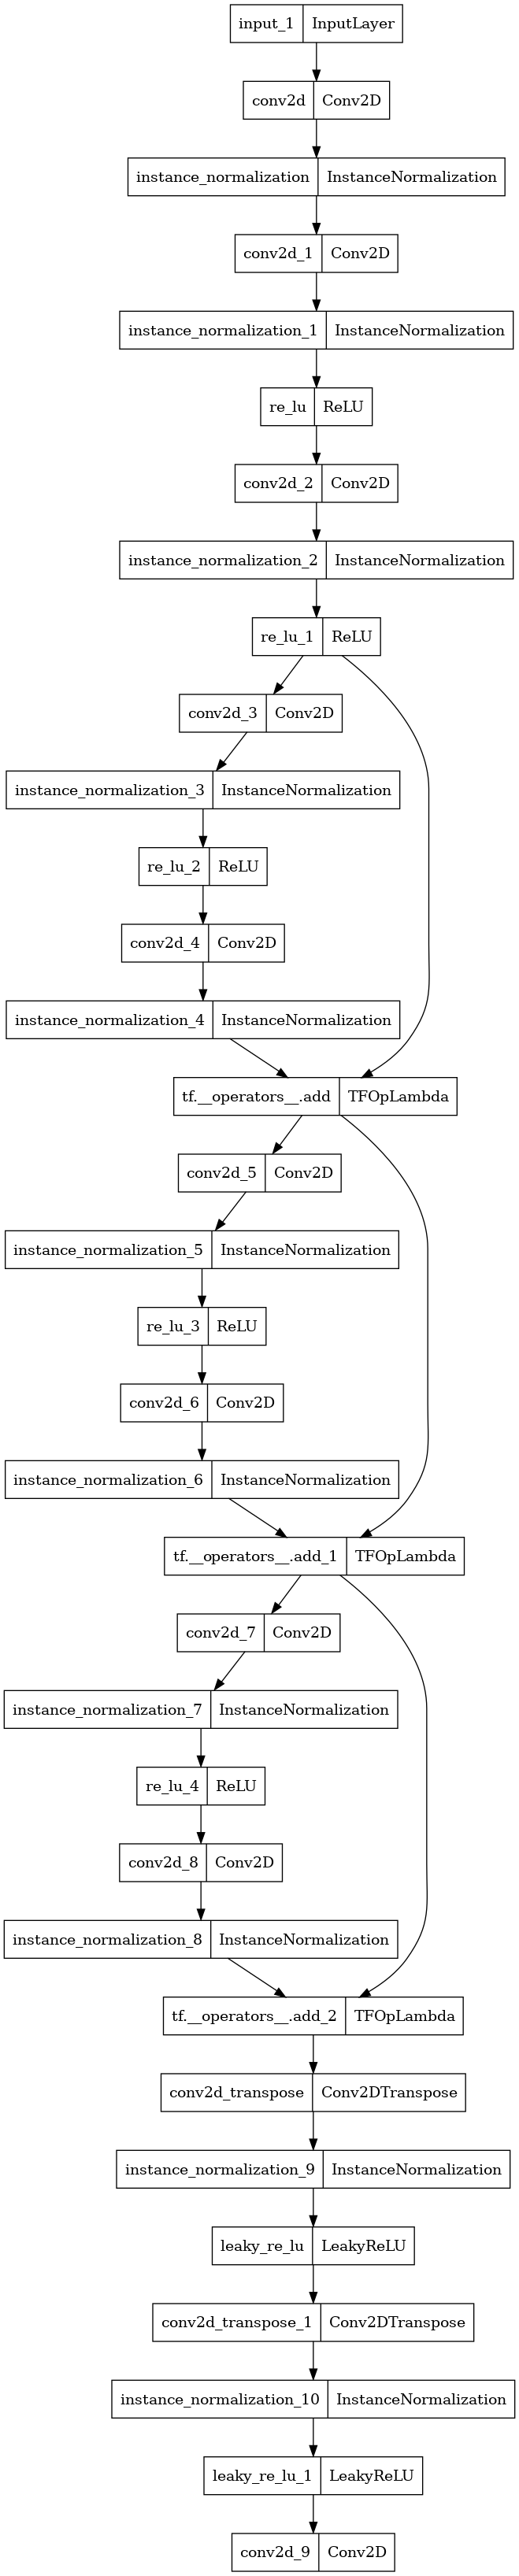

In [29]:
tf.keras.utils.plot_model(gen_AB)

## Discriminator

In [30]:
def Discriminator():

    Input =  layers.Input(shape=(256, 256, 3))
    
    channel = 64
    
    X = FeatureMapBlock(channel, Input, False) #
    X = ContractingBlock(channel*1, X, False, 4, False) #128
    X = ContractingBlock(channel*2, X, False, 4) #64
    X = ContractingBlock(channel*4, X, False, 4) #32

    X = layers.Conv2D(1, kernel_size = 1, padding = "same")(X) #32
    
    
    model = Model(inputs = Input, outputs = X)
    
    return model

In [31]:
disc_A = Discriminator()
disc_B = Discriminator()
disc_A.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_20 (Conv2D)          (None, 256, 256, 64)      9472      
                                                                 
 instance_normalization_22 (  (None, 256, 256, 64)     128       
 InstanceNormalization)                                          
                                                                 
 conv2d_21 (Conv2D)          (None, 128, 128, 64)      65600     
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 128, 128, 64)      0         
                                                                 
 conv2d_22 (Conv2D)          (None, 64, 64, 128)       131200    
                                                           

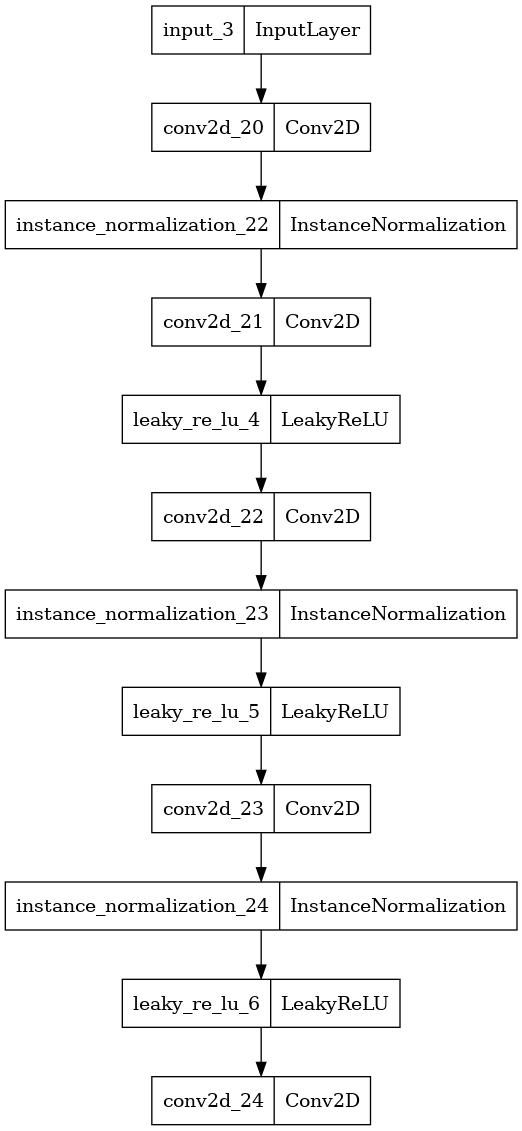

In [32]:
tf.keras.utils.plot_model(disc_A)


## Loss

In [33]:
BCE_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
MSE_loss = tf.keras.losses.MeanSquaredError()
MAE_loss =  tf.keras.losses.MeanAbsoluteError()

## Optimizer

In [34]:
optimizer_disc_A = tf.keras.optimizers.Adam(3e-4, beta_1=0.5)
optimizer_disc_B = tf.keras.optimizers.Adam(3e-4, beta_1=0.5)
optimizer_gen_AB = tf.keras.optimizers.Adam(3e-4, beta_1=0.5)
optimizer_gen_BA = tf.keras.optimizers.Adam(3e-4, beta_1=0.5)

## Discriminator Loss

In [35]:
def get_disc_loss(real_pred, fake_pred, adv_criterion):
    
    ones_label = tf.ones_like(real_pred)
    zeros_label = tf.zeros_like(fake_pred)
    
    disc_loss = (adv_criterion(ones_label, real_pred) + adv_criterion(zeros_label, fake_pred))/2
    
    return disc_loss

## Generator Loss

In [36]:
def get_gen_adversarial_loss(fake_pred, adv_criterion):
    
    ones_label = tf.ones_like(fake_pred)
    
    loss = adv_criterion(ones_label, fake_pred)
    
    return loss
    

In [37]:
def get_cycle_consistency_loss(real_X, cycle_X, cycle_criterion):
    
    cycle_loss = cycle_criterion(real_X, cycle_X)
    
    return cycle_loss 

In [38]:
def get_identity_loss(real_X, identity_X, identity_criterion):
    
    identity_loss = identity_criterion(real_X, identity_X)

    return identity_loss #, identity_X


# Training Loop

In [39]:
def train_CycleGan(real_A, real_B):
    
    lambda_cycle = 10
    lambda_identity = 0.5
    lambda_adv = 1
    
    with tf.GradientTape() as tape:
    
        #fake 
        fake_A =  gen_BA(real_B)
        
        #pred by disc
        real_A_pred = disc_A(real_A)
        fake_A_pred = disc_A(fake_A)
        
        #disc loss    
        disc_loss_A = get_disc_loss(real_A_pred, fake_A_pred, BCE_loss)###
   
    gradients_A = tape.gradient(disc_loss_A, disc_A.trainable_weights)
    optimizer_disc_A.apply_gradients(zip(gradients_A, disc_A.trainable_weights))
    
    with tf.GradientTape() as tape:
    
        #fake 
        fake_B = gen_AB(real_A)
        
        #pred by disc
        real_B_pred = disc_B(real_B)
        fake_B_pred = disc_B(fake_B)
        
        #disc loss    
        disc_loss_B = get_disc_loss(real_B_pred, fake_B_pred, BCE_loss)###
        
    gradients_B = tape.gradient(disc_loss_B, disc_B.trainable_weights)    
    optimizer_disc_B.apply_gradients(zip(gradients_B, disc_B.trainable_weights))
    
        
    with tf.GradientTape(persistent=True) as tape:
        
        #fake 
        fake_A =  gen_BA(real_B)
        fake_B = gen_AB(real_A)
        
        #cycle
        cycle_A = gen_BA(fake_B)
        cycle_B = gen_AB(fake_A)

        #identity 
        iden_B = gen_AB(real_B)
        iden_A = gen_BA(real_A)

        #pred by disc
        fake_B_pred = disc_B(fake_B)

        fake_A_pred = disc_A(fake_A)

        
        #gen loss
        gen_adversarial_loss_AB = get_gen_adversarial_loss(fake_B_pred, BCE_loss)###
        gen_adversarial_loss_BA = get_gen_adversarial_loss(fake_A_pred, BCE_loss)###

        #cycle loss
        total_cycle_loss = get_cycle_consistency_loss(real_A, cycle_A, MAE_loss) + get_cycle_consistency_loss(real_B, cycle_B, MAE_loss) 

        #identity loss
        identity_loss_AB = get_identity_loss(real_B, iden_B, MAE_loss)
        identity_loss_BA = get_identity_loss(real_A, iden_A, MAE_loss)

        #gen loss
        gen_loss_AB = gen_adversarial_loss_AB*lambda_adv + total_cycle_loss*lambda_cycle + identity_loss_AB*lambda_identity
        gen_loss_BA = gen_adversarial_loss_BA*lambda_adv + total_cycle_loss*lambda_cycle + identity_loss_BA*lambda_identity
    
    
    gradients_AB = tape.gradient(gen_loss_AB, gen_AB.trainable_weights)
    gradients_BA = tape.gradient(gen_loss_BA, gen_BA.trainable_weights)
    
    optimizer_gen_AB.apply_gradients(zip(gradients_AB, gen_AB.trainable_weights))
    optimizer_gen_BA.apply_gradients(zip(gradients_BA, gen_BA.trainable_weights))    

    del tape
    gc.collect()

In [40]:
def Train_OneEpoch(EPOCH):
    
    time1 = time.time()
    print("EPOCH ", EPOCH)
    count = 0

    np.random.seed(EPOCH)

    m_idx = np.arange(n1)
    np.random.shuffle(m_idx)

    f_idx = np.arange(len(files_photo))
    np.random.shuffle(f_idx)


    for i in range(n1):
        F_data = read_img(dir_photo, files_photo[f_idx[i]], convert = True)

        M_data2 = M_data[m_idx[i]]

        #Horizontal Flip of Monet image
        if np.random.rand(1)[0] > 0.5:
            train_CycleGan(M_data2[:,::-1,:].reshape(1,256,256,3), F_data.reshape(1,256,256,3))
        else:
            train_CycleGan(M_data2.reshape(1,256,256,3), F_data.reshape(1,256,256,3))


        if (i+1) % 100 == 0:
            print(i+1)



    time2 = time.time()

    time3 = np.round(time2 - time1)

    print("time ", time3, "sec")
    

In [41]:
def Train_Loop(EPOCH, EPOCH_prev):
    
    plot_photo = True
    
    for i in range(EPOCH):
    
        Train_OneEpoch(i + EPOCH_prev)


        real_A = M_data[0:36]
        real_B = F_data[0:36]

        fake_B = gen_AB(real_A)
        fake_A = gen_BA(real_B)
        
        cycle_A = gen_BA(fake_B)
        identity_A = gen_BA(real_A)
        
        cycle_B = gen_AB(fake_A)
        identity_B = gen_AB(real_B)
        
        
        tag = "_" + str(i + EPOCH_prev)
        
        if i + EPOCH_prev == 0:
            np.save("real_A", convert_img(real_A))
            np.save("real_B", convert_img(real_B))
        
        np.save("fake_B" +tag, convert_img(fake_B))
        np.save("cycle_A" +tag, convert_img(cycle_A))
        np.save("identity_A" +tag, convert_img(identity_A))
        np.save("fake_A" +tag, convert_img(fake_A))
        np.save("cycle_B" +tag, convert_img(cycle_B))
        np.save("identity_B" +tag, convert_img(identity_B))
        
        tag = ", epoch " + str(i + EPOCH_prev)
        

    
        if (i + EPOCH_prev) % 2 == 0:
            
            plot_OneLine(real_A, "real_A")
            plot_OneLine(fake_B, "fake_B " + tag)
            plot_OneLine(cycle_A, "cycle_A " + tag)
            plot_OneLine(identity_A, "identity_A " + tag)
            
            plot_OneLine(real_B, "real_B")
            plot_OneLine(fake_A, "fake_A " + tag)
            plot_OneLine(cycle_B, "cycle_B " + tag)
            plot_OneLine(identity_B, "identity_B " + tag)          
            


## Train Cycle GAN

EPOCH  0
100
200
300
time  535.0 sec


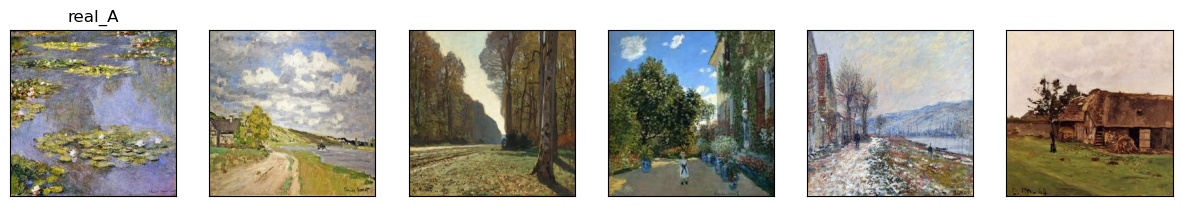

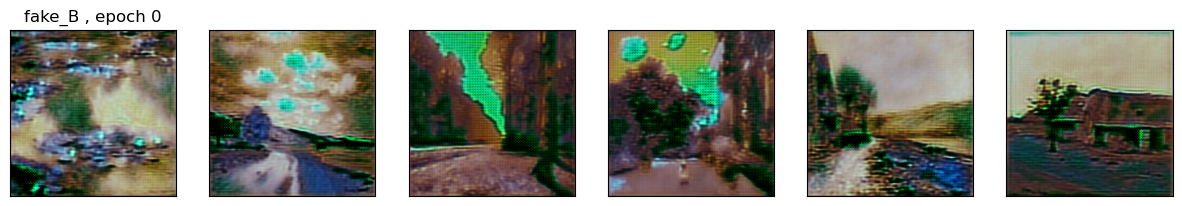

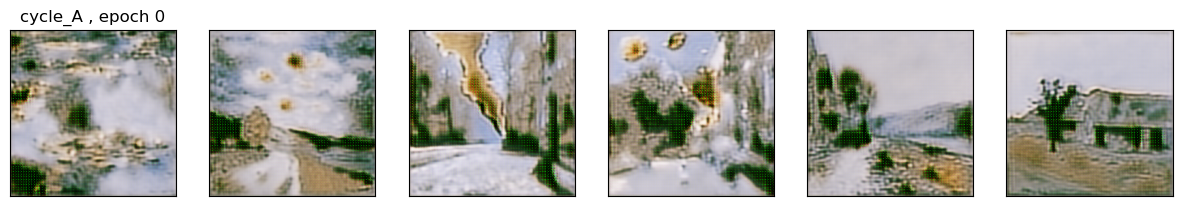

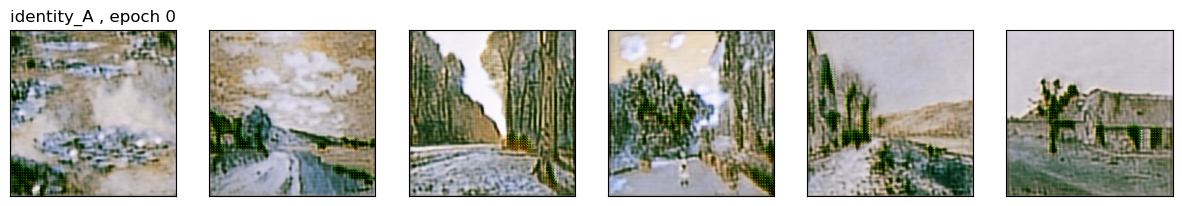

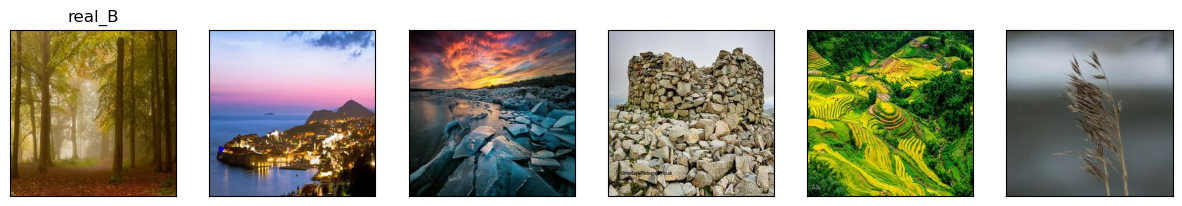

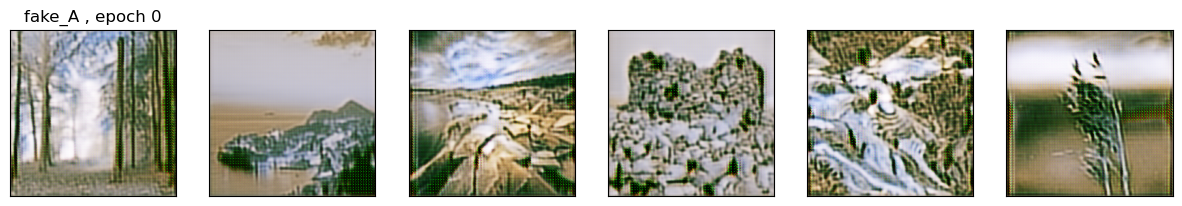

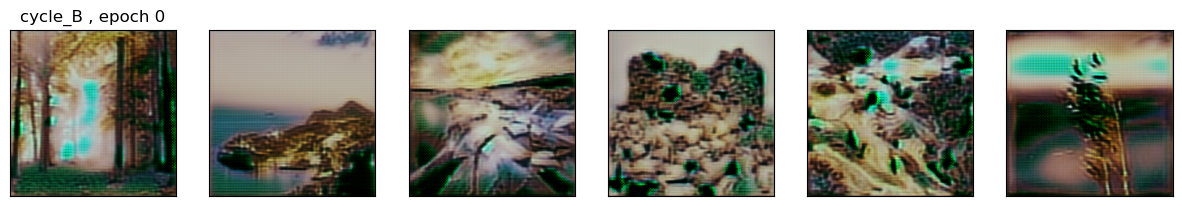

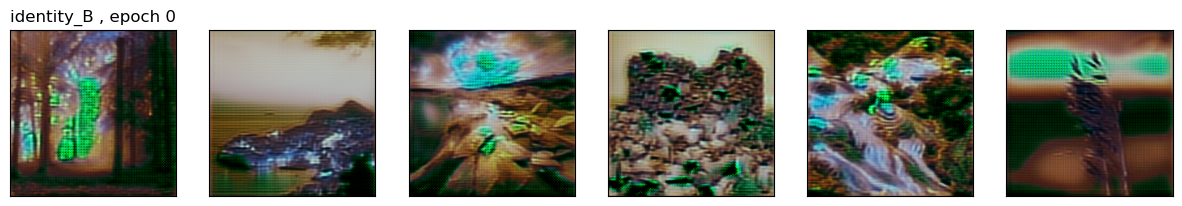

In [43]:
Train_Loop(1, 0)

# Write File

In [44]:
import PIL
! mkdir ../images

In [45]:
n3 = len(files_photo)
n3

7038

In [46]:
for i in range(n3):
    
    real_F = cv2.imread(dir_photo + files_photo[i])[:,:,::-1].reshape(1,256,256,3)
    
    real_F = real_F/(255/2) - 1
    
    fake_A = np.array(gen_BA(real_F))[0]
    
    prediction = convert_img(fake_A).astype(np.uint8)
    
    im = PIL.Image.fromarray(prediction, mode="RGB")
    im.save("../images/" + str(i) + ".jpg")
    



In [47]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'